# Tree Models

The goal is to predict SalePrice

In [2]:
KAGGLE=False # set to True if using the Kaggle version of the dataset
WRITE=False
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import sklearn.preprocessing

from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold,KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import catboost as cb

from xgboost import XGBRegressor
import pickle

import shap
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,KFold, train_test_split
from sklearn.pipeline import Pipeline

plt.rcParams["figure.figsize"] = (20, 10)
from tqdm import tqdm

The data has been pre-processed

In [3]:
alldata=pd.read_csv('./data/Ames_HousePriceLocsDistNoDpl.csv')#, index_col=0) #already cleaned (see work in appendix files)

In [5]:
def label_encode(data):
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    for column_name in data.columns:
        if data[column_name].dtype == object:
            data[column_name] = le.fit_transform(data[column_name])
label_encode(alldata)

In [6]:
def train_test_split_custom(data=alldata,y_var='SalePrice',cols=[]):
    y=data[y_var]
    X=data.drop([y_var],axis=1)
    X= X if not cols else X[cols]
    return train_test_split(X, y, test_size=0.2, random_state=42)


#### Select columns both random forests and Lasso considered important (see previous notebook)

In [7]:
cols_selected=['KitchenQual',
 'GarageYrBlt',
 'BsmtHalfBath',
 'MissingLoc',
 'GrLivArea',
 'ExterQual',
 'PoolQC',
 'HalfBath',
 'GarageCars',
 'LotArea',
 'PavedDrive',
 'WoodDeckSF',
 'BsmtFinSF1',
 'BsmtFullBath',
 'GarageFinish',
 'Heating',
 'TotalBsmtSF',
 'FireplaceQu',
 'distToUI',
 'Foundation',
 'BsmtQual',
 'KitchenAbvGr',
 'MasVnrArea',
 'Condition2',
 'CentralAir',
 'BsmtExposure',
 'RoofStyle',
 'BldgType',
 'TotRmsAbvGrd',
 'BsmtFinType1',
 'MSZoning',
 'GarageArea',
 'SaleCondition',
 'lats',
 'GarageCond',
 'LandSlope',
 'Street',
 'longs',
 'Fireplaces',
 'BedroomAbvGr',
 'FullBath',
 'BsmtUnfSF',
 'YearBuilt',
 'OverallQual',
 'OpenPorchSF',
 'HouseStyle',
 'RoofMatl',
 'GarageType',
 'YearRemodAdd',
 'LotFrontage',
 '1stFlrSF',
 'OverallCond']

In [8]:
len(cols_selected)

52

# XGBoost

In [11]:
class TrainXGB:
    def __init__(self,data,model,grid, y_var='SalePrice',cols=[],grid_search=True, n_iters_rs=None):
        self.data = data
        self.cols = cols
        self.y_var = y_var
        self.model=model
        self.grid=grid
        self.X_train, self.X_test, self.y_train, self.y_test = self.train_test_split_custom()  
        self.grid_search = grid_search # True if grid search, False if random search
        self.n_iters_rs = n_iters_rs if n_iters_rs else 10
 
    def __call__(self):    
        cv=KFold(n_splits=5, random_state=42, shuffle=True)

        if self.grid_search:
            search_cv = GridSearchCV(cv=cv,
                        estimator=self.model,
                        n_jobs=2,
                        param_grid=self.grid,
                        return_train_score=True,
                        verbose=1)
        else:
            search_cv = RandomizedSearchCV(cv=cv,
                        estimator=self.model,
                        n_jobs=2,
                        param_distributions=self.grid,
                        return_train_score=True,
                        verbose=1,
                        n_iter=self.n_iters_rs)


        %time obj = search_cv.fit(self.X_train, self.y_train)

        
        preds = search_cv.predict(self.X_test)
        kf = KFold(n_splits=12, random_state=42, shuffle=True)

        print(f'r2 score on train: {r2_score(search_cv.predict(self.X_train), self.y_train)}\nr2 score on test: {r2_score(self.y_test, preds)}')
        return search_cv

    def train_test_split_custom(self):
        y=self.data[self.y_var]
        X=self.data.drop([self.y_var],axis=1)
        X= X if not self.cols else X[self.cols]
        return train_test_split(X, y, test_size=0.2, random_state=42)



In [12]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
grid_xgb={'n_estimators':range(4000,6000,1000)}#, 'max_depth':range(3,6)}
xgboost = XGBRegressor(learning_rate=0.01,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.8,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=42,
                       reg_alpha=0.00006,
                       random_state=42)
model_xgb=TrainXGB(data=alldata, cols= cols_selected ,model=xgboost,grid = grid_xgb,grid_search=False, n_iters_rs=10)()


The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 1min 2s, sys: 952 ms, total: 1min 2s
Wall time: 1min 15s
r2 score on train: 0.9973525840026357
r2 score on test: 0.9283442150887822


- First, try to get max_depth right

In [19]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
grid_xgb={'n_estimators':[200,1000],
        'reg_alpha':[.0006,.001,.1],
        'gamma':[1],
        'max_depth':np.arange(2,10)}#, 'max_depth':range(3,6)}
xgboost = XGBRegressor(learning_rate=0.01,
                       max_depth=4,
                       min_child_weight=0,
                      # gamma=0.6,
                       subsample=0.8,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=42,
                      # reg_alpha=0.00006,
                       random_state=42)
model_xgb=TrainXGB(data=alldata, cols= cols_selected ,model=xgboost,grid = grid_xgb,grid_search=False, n_iters_rs=10)()
print(f"\ngamma:{model_xgb.best_estimator_.max_depth}\nreg_alpha: {model_xgb.best_estimator_.reg_alpha}\nnum_estimators: {model_xgb.best_estimator_.reg_alpha}\ngamma:{model_xgb.best_estimator_.gamma}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 15.1 s, sys: 220 ms, total: 15.3 s
Wall time: 1min
r2 score on train: 0.9866210648241653
r2 score on test: 0.9233869028258181

gamma:5
reg_alpha: 0.0006
num_estimators: 0.0006
gamma:1


- Now, try to regularize

In [20]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
grid_xgb={'n_estimators':[200,1000,2000],
        'reg_alpha':[.001,.1],
        'gamma':[1],
        'max_depth':[6]}#, 'max_depth':range(3,6)}
xgboost = XGBRegressor(learning_rate=0.01,
                       max_depth=4,
                       min_child_weight=0,
                      # gamma=0.6,
                       subsample=0.8,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=42,
                      # reg_alpha=0.00006,
                       random_state=42)
model_xgb=TrainXGB(data=alldata, cols= cols_selected ,model=xgboost,grid = grid_xgb,grid_search=False, n_iters_rs=10)()
print(f"\ngamma:{model_xgb.best_estimator_.max_depth}\nreg_alpha: {model_xgb.best_estimator_.reg_alpha}\nnum_estimators: {model_xgb.best_estimator_.n_estimators}\ngamma:{model_xgb.best_estimator_.gamma}")


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 30.8 s, sys: 444 ms, total: 31.2 s
Wall time: 1min 10s
r2 score on train: 0.9980455954488381
r2 score on test: 0.922983113946422

gamma:6
reg_alpha: 0.1
num_estimators: 2000
gamma:1


- Note: To save time, I did not rerun some of the cells below since they were run previously.  Instead, I selected some modesl for future work and reran the future importances.

In [157]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
grid_xgb={'n_estimators':[2000],
        'learning_rate':[.01],
        'reg_alpha':[.1,.2,.3],
        'gamma':[5],
        'max_depth':[6],
        'subsample':[.5]}#, 'max_depth':range(3,6)}
xgboost = XGBRegressor(#learning_rate=0.01,
                       max_depth=4,
                       min_child_weight=0,
                      # gamma=0.6,
                       #subsample=0.8,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=42,
                      # reg_alpha=0.00006,
                       random_state=42)
model_xgb=TrainXGB(data=alldata, cols= cols_selected ,model=xgboost,grid = grid_xgb,grid_search=False, n_iters_rs=10)()
print(f"\nmax_depth:{model_xgb.best_estimator_.max_depth}\nlearning_rate:{model_xgb.best_estimator_.learning_rate}\nreg_alpha: {model_xgb.best_estimator_.reg_alpha}\nnum_estimators: {model_xgb.best_estimator_.n_estimators}\ngamma:{model_xgb.best_estimator_.gamma}")


The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 3 candidates, totalling 15 fits
CPU times: user 32.6 s, sys: 348 ms, total: 32.9 s
Wall time: 1min
r2 score on train: 0.9955304367198257
r2 score on test: 0.9295693369735181

max_depth:6
learning_rate:0.01
reg_alpha: 0.2
num_estimators: 2000
gamma:5


In [158]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
grid_xgb={'n_estimators':[2000],
        'learning_rate':[.01],
        'reg_alpha':[.1,.2,.3],
        'gamma':[5],
        'max_depth':[6],
        'subsample':[.4]}#, 'max_depth':range(3,6)}
xgboost = XGBRegressor(#learning_rate=0.01,
                       max_depth=4,
                       min_child_weight=0,
                      # gamma=0.6,
                       #subsample=0.8,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=42,
                      # reg_alpha=0.00006,
                       random_state=42)
model_xgb=TrainXGB(data=alldata, cols= cols_selected ,model=xgboost,grid = grid_xgb,grid_search=False, n_iters_rs=10)()
print(f"\nmax_depth:{model_xgb.best_estimator_.max_depth}\nlearning_rate:{model_xgb.best_estimator_.learning_rate}\nreg_alpha: {model_xgb.best_estimator_.reg_alpha}\nnum_estimators: {model_xgb.best_estimator_.n_estimators}\ngamma:{model_xgb.best_estimator_.gamma}")


The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 3 candidates, totalling 15 fits
CPU times: user 29.6 s, sys: 536 ms, total: 30.2 s
Wall time: 1min
r2 score on train: 0.9940059166729079
r2 score on test: 0.933201256867623

max_depth:6
learning_rate:0.01
reg_alpha: 0.1
num_estimators: 2000
gamma:5


In [159]:
pickle.dump(model_xgb,open('./models/xgb_9332_51feats_.4subsample','wb'))

In [160]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
grid_xgb={'n_estimators':[2000],
        'learning_rate':[.01],
        'reg_alpha':[.1,.2,.3],
        'gamma':[5],
        'max_depth':[6],
        'subsample':[.3]}#, 'max_depth':range(3,6)}
xgboost = XGBRegressor(#learning_rate=0.01,
                       max_depth=4,
                       min_child_weight=0,
                      # gamma=0.6,
                       #subsample=0.8,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=42,
                      # reg_alpha=0.00006,
                       random_state=42)
model_xgb=TrainXGB(data=alldata, cols= cols_selected ,model=xgboost,grid = grid_xgb,grid_search=False, n_iters_rs=10)()
print(f"\nmax_depth:{model_xgb.best_estimator_.max_depth}\nlearning_rate:{model_xgb.best_estimator_.learning_rate}\nreg_alpha: {model_xgb.best_estimator_.reg_alpha}\nnum_estimators: {model_xgb.best_estimator_.n_estimators}\ngamma:{model_xgb.best_estimator_.gamma}")


The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 3 candidates, totalling 15 fits
CPU times: user 27.4 s, sys: 384 ms, total: 27.7 s
Wall time: 52.8 s
r2 score on train: 0.9912793207684324
r2 score on test: 0.9310317258915519

max_depth:6
learning_rate:0.01
reg_alpha: 0.2
num_estimators: 2000
gamma:5


In [161]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
grid_xgb={'n_estimators':[2000],
        'learning_rate':[.01],
        'reg_alpha':[.2],
        'gamma':[5],
        'max_depth':[6],
        'subsample':[.3],
        'colsample_bytree':[.2,.3,.4,.5,.6,.7]}#, 'max_depth':range(3,6)}
xgboost = XGBRegressor(#learning_rate=0.01,
                       max_depth=4,
                       min_child_weight=0,
                      # gamma=0.6,
                       #subsample=0.8,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=42,
                      # reg_alpha=0.00006,
                       random_state=42)
model_xgb=TrainXGB(data=alldata, cols= cols_selected ,model=xgboost,grid = grid_xgb,grid_search=False, n_iters_rs=10)()
print(f"\nmax_depth:{model_xgb.best_estimator_.max_depth}\nlearning_rate:{model_xgb.best_estimator_.learning_rate}\nreg_alpha: {model_xgb.best_estimator_.reg_alpha}\nnum_estimators: {model_xgb.best_estimator_.n_estimators}\ngamma:{model_xgb.best_estimator_.gamma}")


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 25.9 s, sys: 400 ms, total: 26.3 s
Wall time: 1min 27s
r2 score on train: 0.9912913378334266
r2 score on test: 0.9328567171505722

max_depth:6
learning_rate:0.01
reg_alpha: 0.2
num_estimators: 2000
gamma:5


In [21]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
grid_xgb={'n_estimators':[1000],
        'learning_rate':[.01],
        'reg_alpha':[.2],
        'gamma':[5],
        'max_depth':[6],
        'subsample':[.3],
        'colsample_bytree':[.2,.3,.4,.5,.6,.7]}#, 'max_depth':range(3,6)}
xgboost = XGBRegressor(#learning_rate=0.01,
                       max_depth=4,
                       min_child_weight=0,
                      # gamma=0.6,
                       #subsample=0.8,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=42,
                      # reg_alpha=0.00006,
                       random_state=42)
model_xgb=TrainXGB(data=alldata, cols= cols_selected ,model=xgboost,grid = grid_xgb,grid_search=False, n_iters_rs=10)()
print(f"\nmax_depth:{model_xgb.best_estimator_.max_depth}\nlearning_rate:{model_xgb.best_estimator_.learning_rate}\nreg_alpha: {model_xgb.best_estimator_.reg_alpha}\nnum_estimators: {model_xgb.best_estimator_.n_estimators}\ngamma:{model_xgb.best_estimator_.gamma}")


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 13.3 s, sys: 172 ms, total: 13.5 s
Wall time: 50.6 s
r2 score on train: 0.9785200940447292
r2 score on test: 0.930077221380623

max_depth:6
learning_rate:0.01
reg_alpha: 0.2
num_estimators: 1000
gamma:5


In [22]:
pickle.dump(model_xgb,open('./models/xgb_9300_51feats_regularized','wb'))

Text(0.5, 1.0, 'XGBoost Feature Importances')

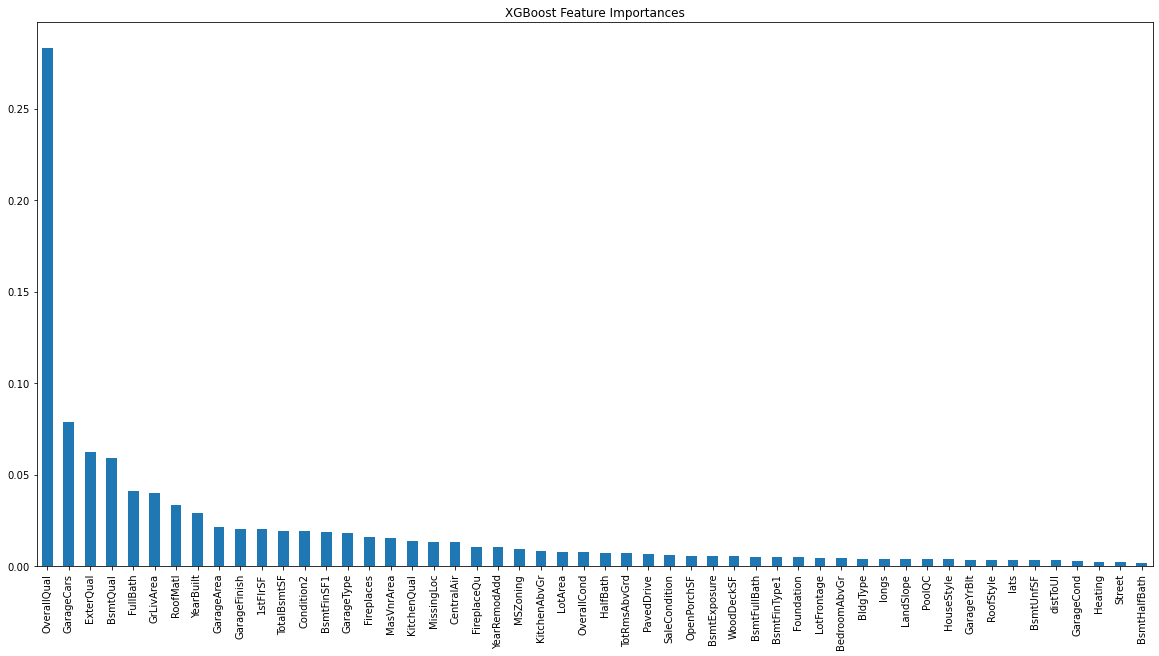

In [23]:
pd.Series(model_xgb.best_estimator_.feature_importances_,alldata[cols_selected].columns).sort_values(ascending=False).plot(kind='bar')
plt.title('XGBoost Feature Importances')

In [164]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
grid_xgb={'n_estimators':[500],
        'learning_rate':[.01],
        'reg_alpha':[.2],
        'gamma':[5],
        'max_depth':[6],
        'subsample':[.3],
        'colsample_bytree':[.2,.3,.4,.5,.6,.7]}#, 'max_depth':range(3,6)}
xgboost = XGBRegressor(#learning_rate=0.01,
                       max_depth=4,
                       min_child_weight=0,
                      # gamma=0.6,
                       #subsample=0.8,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=42,
                      # reg_alpha=0.00006,
                       random_state=42)
model_xgb=TrainXGB(data=alldata, cols= cols_selected ,model=xgboost,grid = grid_xgb,grid_search=False, n_iters_rs=10)()
print(f"\nmax_depth:{model_xgb.best_estimator_.max_depth}\nlearning_rate:{model_xgb.best_estimator_.learning_rate}\nreg_alpha: {model_xgb.best_estimator_.reg_alpha}\nnum_estimators: {model_xgb.best_estimator_.n_estimators}\ngamma:{model_xgb.best_estimator_.gamma}")


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 7.08 s, sys: 148 ms, total: 7.23 s
Wall time: 22.8 s
r2 score on train: 0.9584640204278082
r2 score on test: 0.9219215072691608

max_depth:6
learning_rate:0.01
reg_alpha: 0.2
num_estimators: 500
gamma:5


In [13]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
#Try grid search in n_estimators 200-400 range
grid_xgb={'n_estimators':np.arange(200,400,20),
        'learning_rate':[.01],
        'reg_alpha':[.2],
        'gamma':[5],
        'max_depth':[6],
        'subsample':[.3],
        'colsample_bytree':[.6]}#, 'max_depth':range(3,6)}
xgboost = XGBRegressor(#learning_rate=0.01,
                       max_depth=4,
                       min_child_weight=0,
                      # gamma=0.6,
                       #subsample=0.8,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=42,
                      # reg_alpha=0.00006,
                       random_state=42)
model_xgb=TrainXGB(data=alldata, cols= cols_selected ,model=xgboost,grid = grid_xgb,grid_search=True)()
print(f"\nmax_depth:{model_xgb.best_estimator_.max_depth}\nlearning_rate:{model_xgb.best_estimator_.learning_rate}\nreg_alpha: {model_xgb.best_estimator_.reg_alpha}\nnum_estimators: {model_xgb.best_estimator_.n_estimators}\ngamma:{model_xgb.best_estimator_.gamma}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 5.31 s, sys: 72.1 ms, total: 5.38 s
Wall time: 23.8 s
r2 score on train: 0.9383825894790574
r2 score on test: 0.9110203568846585

max_depth:6
learning_rate:0.01
reg_alpha: 0.2
num_estimators: 380
gamma:5


In [175]:
pickle.dump(model_xgb,open('./models/xgb_911_51feats_2_7pct_overfit','wb'))

Text(0.5, 1.0, 'XGBoost Feature Importances')

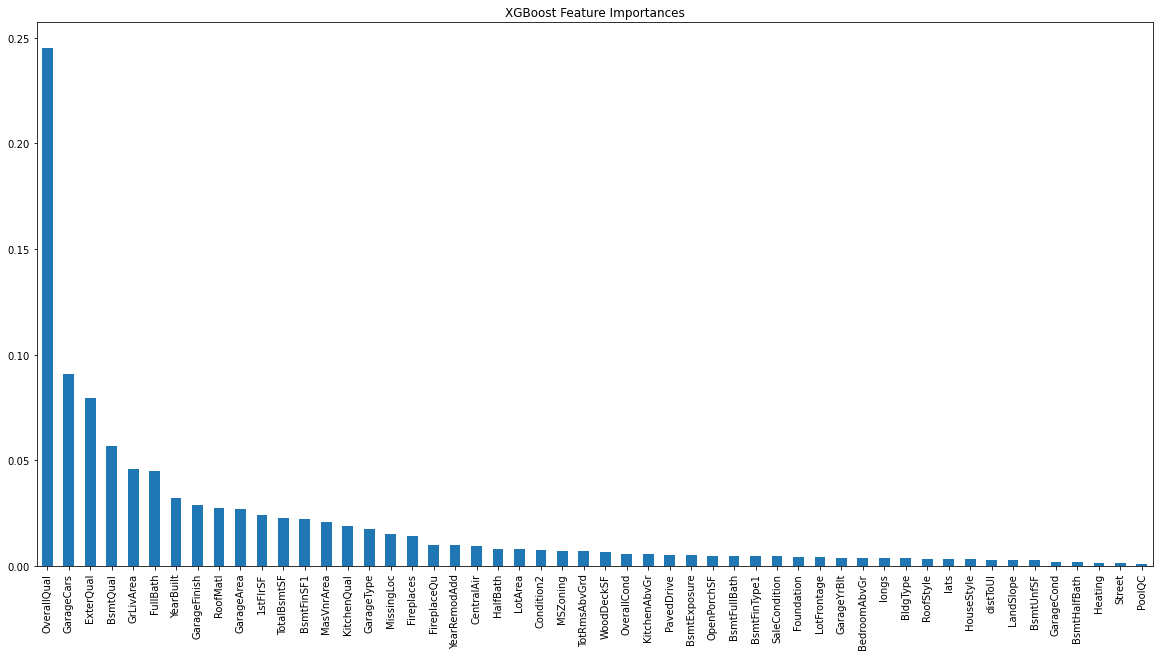

In [18]:
pd.Series(model_xgb.best_estimator_.feature_importances_,alldata[cols_selected].columns).sort_values(ascending=False).plot(kind='bar')
plt.title('XGBoost Feature Importances')

- XGBRegressor overfits since r2 score on train is 0.9997968686776598 and r2 score on test is 0.9213233946437086

In [24]:
# sorted_feature_importance = model_xgb.best_estimator_.feature_importances_.argsort()
# explainer = shap.TreeExplainer(model_xgb.best_estimator_)
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test, feature_names = alldata.columns[sorted_feature_importance])